# **CIVP 이상탐지 AI 모델**

## **필요한 라이브러리 로드**

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## **데이터 통합 후 인덱스 초기화**

In [2]:
forders = os.listdir('C:/Users/Admin/OneDrive/바탕 화면/주피터 코드 모음/test') # 경로 재설정하기

In [3]:
cd C:/Users/Admin/OneDrive/바탕 화면/주피터 코드 모음/test 

C:\Users\Admin\OneDrive\바탕 화면\주피터 코드 모음\test


In [4]:
df1 = pd.DataFrame()

for files in forders:
    df= pd.read_csv(files, encoding='cp949')
    df1 = pd.concat([df1, df])
    
    
df1 = df1.reset_index()


## **이상탐지 항목 생성을 위한 전처리**

In [5]:
df1['person_max_stream']= 0
df1['person_max_stream'].unique()

df1.loc[df1['person_max_stream']==0,['person_max_stream']] = 20

df1['count_person_stream'] = 0

df1['count_person_stream'].unique()

df1.loc[df1['count_person_stream']==0,['count_person_stream']] = df1['play_in_term'] / df1['person_max_stream']

df1['fake_stream_count'] = 0
df1['fake_stream_count'].unique()

df1.loc[df1['fake_stream_count']==0, ['fake_stream_count']]= df1['count_person_stream']- df1['listen_in_term']
df1 = df1.dropna(axis =0)
    

column = df1['fake_stream_count'].values.reshape(-1, 1)  

## **오토인코더 모델 생성 후 학습**

In [6]:
# 데이터 정규화
normalized_column = (column - np.mean(column)) / np.std(column)

# 오토인코더 생성
input_dim = normalized_column.shape[1]
encoding_dim = 256
    
input_layer = tf.keras.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='softmax')(input_layer) #활성화 함수 무조건 바꾸기 기존: softmax
decoder = layers.Dense(input_dim)(encoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

# 오토인코더 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 학습훈련
autoencoder.fit(normalized_column, normalized_column, epochs=100, batch_size=512, verbose=1)

# 복원 오류 예측
reconstructed_column = autoencoder.predict(normalized_column)

# 복원 오류 계산
reconstruction_error = np.mean(np.square(normalized_column - reconstructed_column), axis=1)

# 복원 오류의 평균과 표준편차 계산
error_mean = np.mean(reconstruction_error)
error_std = np.std(reconstruction_error)

# 이상탐지 한계점 정립
threshold = 3 * error_std

# 이상치 기준 수립
anomalies = reconstruction_error > threshold


Epoch 1/100
7691/7691 [==============================] - 14s 2ms/step - loss: 0.6137
Epoch 2/100
7691/7691 [==============================] - 14s 2ms/step - loss: 0.4051
Epoch 3/100
7691/7691 [==============================] - 13s 2ms/step - loss: 0.3274
Epoch 4/100
7691/7691 [==============================] - 14s 2ms/step - loss: 0.2794
Epoch 5/100
7691/7691 [==============================] - 14s 2ms/step - loss: 0.2469
Epoch 6/100
7691/7691 [==============================] - 13s 2ms/step - loss: 0.2224
Epoch 7/100
7691/7691 [==============================] - 13s 2ms/step - loss: 0.2026
Epoch 8/100
7691/7691 [==============================] - 13s 2ms/step - loss: 0.1860
Epoch 9/100
7691/7691 [==============================] - 13s 2ms/step - loss: 0.1718
Epoch 10/100
7691/7691 [==============================] - 14s 2ms/step - loss: 0.1602
Epoch 11/100
7691/7691 [==============================] - 14s 2ms/step - loss: 0.1497
Epoch 12/100
7691/7691 [==============================] - 14s 2

In [7]:
# 이상치 데이터 출력
anomaly_indices = np.where(anomalies)[0]
print("Anomaly indices:", anomaly_indices)

Anomaly indices: [ 760115  760118 1833815 2072255 2213506 2254925 2305095 2314146 2349011
 2363401 2384679 2476853 2510531 2745785 2761526 2798218 2864668 3160535
 3175264 3212503 3234726 3447416 3453400 3457638 3646180 3699860 3713090
 3749022 3889375]


## **시각화 및 전체 테이블 표시**

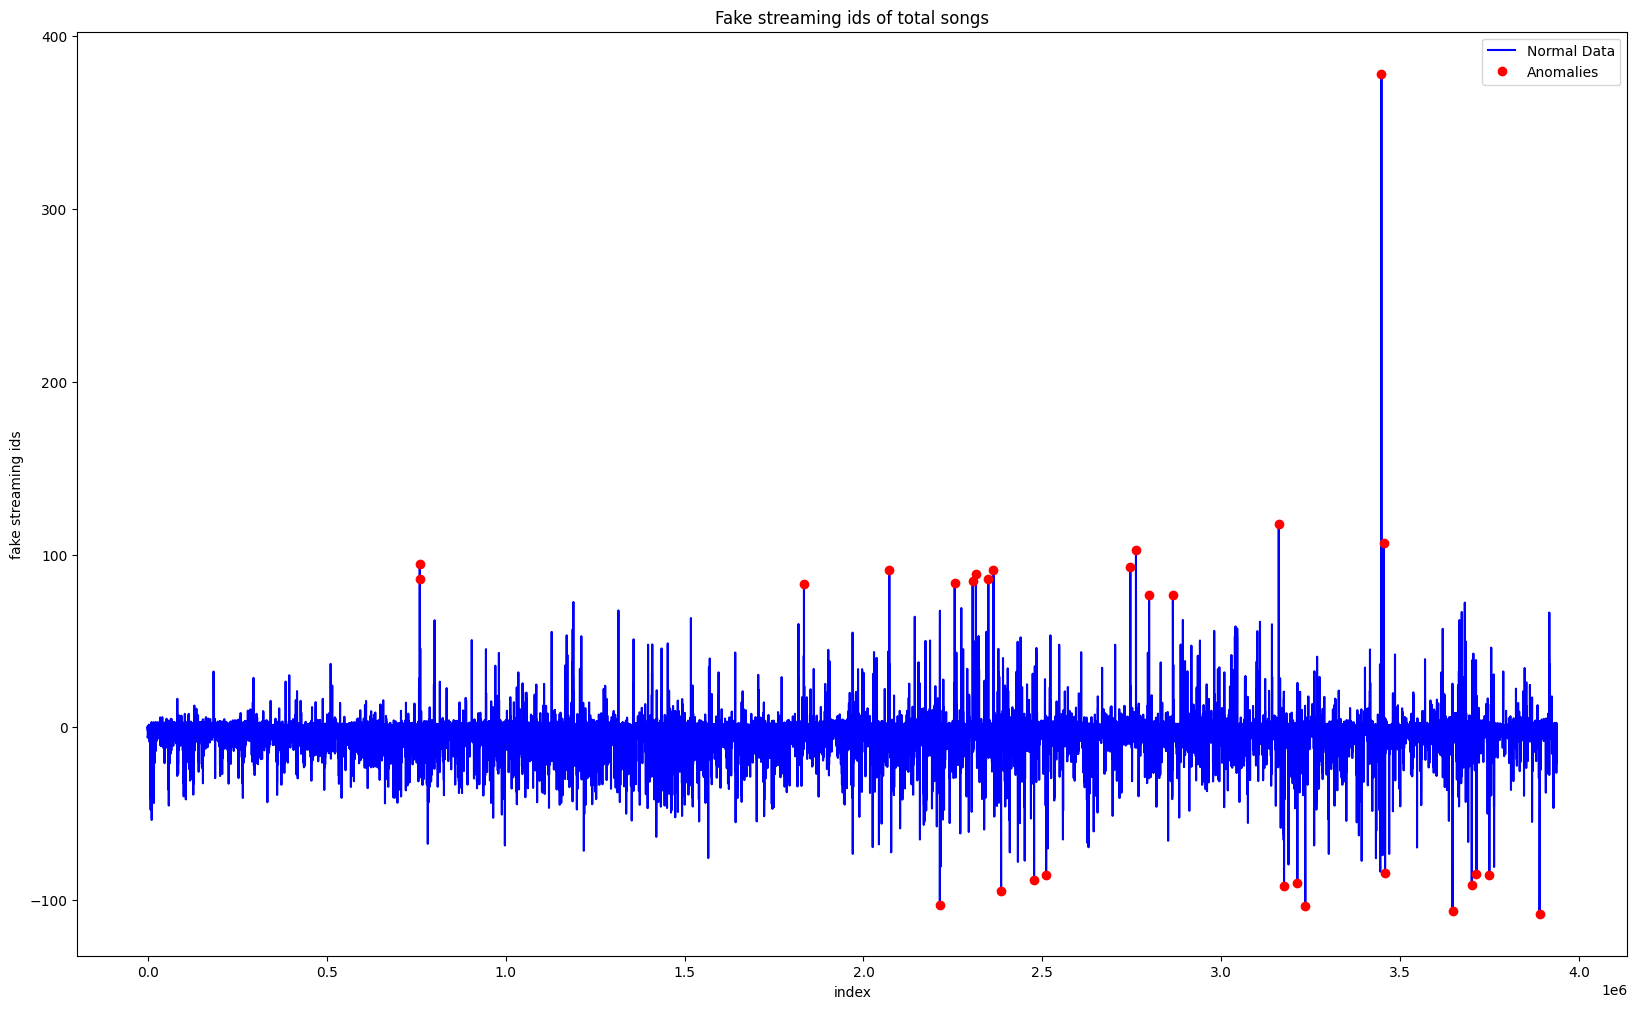

anomaly index: Index([ 763493,  763496, 1838965, 2077741, 2219256, 2260739, 2310989, 2320044,
       2354965, 2369383, 2390687, 2482982, 2516708, 2752232, 2767981, 2804730,
       2871245, 3167485, 3182220, 3219491, 3241736, 3454972, 3460975, 3465213,
       3653977, 3707709, 3720971, 3756974, 3897474],
      dtype='int64')


In [8]:
# 시각화    
plt.figure(figsize=(20, 12))
plt.plot(normalized_column, color='b', label='Normal Data')
plt.plot(anomaly_indices, normalized_column[anomaly_indices], 'ro', label='Anomalies')
plt.xlabel('index')
plt.ylabel('fake streaming ids')
plt.title("Fake streaming ids of total songs")
plt.legend()
plt.show()
anomaly_location = df1[anomalies].index
print("anomaly index:", anomaly_location)

In [9]:
#전체 데이터 표 출력
anomalies_full = df1.iloc[np.where(anomalies)]
anomalies_full

,index,date,rank,change,sing_id,subject,singer,rank_out_term,play_in_term,listen_in_term,play_total,listen_total,person_max_stream,count_person_stream,fake_stream_count
763493,496,2020/05/03/1,247,NEW,89186138,BLUE,하성운,2322,1826341.0,13778.0,11697817,297853,20,91317.05,77539.05
763496,499,2020/05/03/1,250,NEW,88656476,BIRD,하성운,2513,1986610.0,14350.0,22987617,491911,20,99330.50,84980.50
1838965,3218,2020/10/29/12,219,NEW,87730738,눈사람,정승환,5790,3411068.0,96025.0,47818879,2133539,20,170553.40,74528.40
2077741,2744,2020/12/08/10,245,NEW,88421579,180도,벤,6627,3463172.0,91301.0,54261232,2180574,20,173158.60,81857.60
2219256,259,2021/01/01/1,10,NEW,81043108,내가 제일 잘 나가,2NE1,8779,1265986.0,155784.0,5540948,777700,20,63299.30,-92484.70
2260739,5742,2021/01/07/22,243,NEW,87579522,그날처럼,장덕철,4254,2657639.0,57417.0,89705216,2751023,20,132881.95,75464.95
2310989,1992,2021/01/16/7,243,NEW,90612173,깨워 (Who U Are),강다니엘,1992,1804754.0,13736.0,8978586,202415,20,90237.70,76501.70
2320044,5047,2021/01/17/20,48,NEW,87538960,My Way,이수 (엠씨더맥스),8772,5119215.0,176123.0,54742005,2282870,20,255960.75,79837.75
2354965,3968,2021/01/23/15,219,NEW,89586709,차가워진 이 바람엔 우리가 써있어 (Bad Love),HYNN (박혜원),5395,3091663.0,77352.0,16304241,1018711,20,154583.15,77231.15
2369383,386,2021/01/26/1,137,NEW,88773174,소우주 (Mikrokosmos),방탄소년단,6859,3483395.0,92095.0,38532799,1587648,20,174169.75,82074.75
